### 一、数据集

In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # 获取第一个图对象

print()
print(data)
print('===============================================================================================================')

# 获得这张图的一些统计信息
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [2]:
print(int(data.train_mask.sum())) # 训练集节点数
print(int(data.val_mask.sum())) # 验证集节点数
print(int(data.test_mask.sum())) # 测试集节点数

60
500
1000


类别 0: 4103 个样本
类别 1: 7739 个样本
类别 2: 7875 个样本


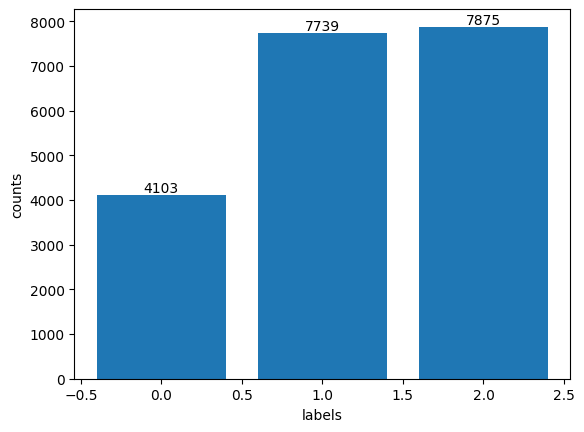

In [3]:
import matplotlib.pyplot as plt

# 统计每个类别的数量
unique_labels, counts = torch.unique(data.y, return_counts=True)

# 打印每个类别的数量
for label, count in zip(unique_labels, counts):
    print(f"类别 {label.item()}: {count.item()} 个样本")

# 使用直方图可视化
plt.bar(unique_labels.numpy(), counts.numpy())
plt.xlabel('labels')
plt.ylabel('counts')

# 在每个条形上方添加数字标签
for label, count in zip(unique_labels, counts):
    plt.text(label.item(), count.item(), str(count.item()), ha='center', va='bottom')

plt.show()

### 二、Full-batch加载数据训练

In [4]:
def train(): 
    model.train() # 训练模式
    optimizer.zero_grad()  # 梯度清0
    train_outputs = model(data.x, data.edge_index)  # 前向传播
    loss = criterion(train_outputs[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 参数更新
    
    return loss
    
def test():    
    model.eval() # 测试模式
    outputs = model(data.x, data.edge_index)  # 预测输出
    preds = outputs.argmax(dim=1) # 测试预测
    
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = preds[mask] == data.y[mask]  # 预测正确
        accs.append(int(correct.sum()) / int(mask.sum()))  # 准确率
    
    return accs

In [5]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, output_channels=3):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(500, 32)  
        self.conv2 = GCNConv(32, output_channels)
        
        self.dp = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        
        x = F.relu(self.conv1(x, edge_index)) # (num_nodes, num_features=500) ——> (num_nodes, num_features=32)
        x = self.conv2(x, edge_index) # (num_nodes, num_features=32) ——> (num_nodes, dataset.num_classes=3)
        
        return x

model = GCN()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

GCN(
  (conv1): GCNConv(500, 32)
  (conv2): GCNConv(32, 3)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 16131


In [6]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

start_time = time.time()

for epoch in range(101):
    loss = train()
    train_acc, val_acc, test_acc = test()

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'
              .format(epoch, loss, train_acc, val_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch #000, Loss: 1.0993, Train_Accuracy: 0.3500, Val_Accuracy: 0.1980, Test_Accuracy: 0.1860
Epoch #010, Loss: 0.9227, Train_Accuracy: 0.9333, Val_Accuracy: 0.7180, Test_Accuracy: 0.6790
Epoch #020, Loss: 0.6597, Train_Accuracy: 0.9500, Val_Accuracy: 0.7500, Test_Accuracy: 0.7280
Epoch #030, Loss: 0.4127, Train_Accuracy: 0.9500, Val_Accuracy: 0.7660, Test_Accuracy: 0.7480
Epoch #040, Loss: 0.2422, Train_Accuracy: 0.9667, Val_Accuracy: 0.7840, Test_Accuracy: 0.7650
Epoch #050, Loss: 0.1456, Train_Accuracy: 1.0000, Val_Accuracy: 0.7920, Test_Accuracy: 0.7650
Epoch #060, Loss: 0.0962, Train_Accuracy: 1.0000, Val_Accuracy: 0.7880, Test_Accuracy: 0.7700
Epoch #070, Loss: 0.0718, Train_Accuracy: 1.0000, Val_Accuracy: 0.7800, Test_Accuracy: 0.7730
Epoch #080, Loss: 0.0597, Train_Accuracy: 1.0000, Val_Accuracy: 0.7740, Test_Accuracy: 0.7770
Epoch #090, Loss: 0.0531, Train_Accuracy: 1.0000, Val_Accuracy: 0.7760, Test_Accuracy: 0.7820
Epoch #100, Loss: 0.0489, Train_Accuracy: 1.0000, Val_Accura

In [7]:
import torch.nn as nn
from torch_geometric.nn import ClusterGCNConv

class ClusterGCN(nn.Module):
    def __init__(self, output_channels=3):
        super(ClusterGCN, self).__init__()

        self.conv1 = ClusterGCNConv(500, 32, diag_lambda=1)  
        self.conv2 = ClusterGCNConv(32, output_channels, diag_lambda=1)
        
        self.dp = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        
        x = F.relu(self.conv1(x, edge_index)) # (num_nodes, num_features=500) ——> (num_nodes, num_features=32)
        x = self.conv2(x, edge_index) # (num_nodes, num_features=32) ——> (num_nodes, dataset.num_classes=3)
        
        return x

model = ClusterGCN()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

ClusterGCN(
  (conv1): ClusterGCNConv(500, 32, diag_lambda=1)
  (conv2): ClusterGCNConv(32, 3, diag_lambda=1)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 32227


In [8]:
# 重置先前训练的模型权重
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [9]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

start_time = time.time()

for epoch in range(101):
    loss = train()
    train_acc, val_acc, test_acc = test()

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'
              .format(epoch, loss, train_acc, val_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch #000, Loss: 1.1091, Train_Accuracy: 0.4833, Val_Accuracy: 0.4580, Test_Accuracy: 0.4500
Epoch #010, Loss: 0.4512, Train_Accuracy: 0.9833, Val_Accuracy: 0.7580, Test_Accuracy: 0.7480
Epoch #020, Loss: 0.0923, Train_Accuracy: 0.9833, Val_Accuracy: 0.7520, Test_Accuracy: 0.7580
Epoch #030, Loss: 0.0215, Train_Accuracy: 1.0000, Val_Accuracy: 0.7560, Test_Accuracy: 0.7530
Epoch #040, Loss: 0.0087, Train_Accuracy: 1.0000, Val_Accuracy: 0.7660, Test_Accuracy: 0.7540
Epoch #050, Loss: 0.0061, Train_Accuracy: 1.0000, Val_Accuracy: 0.7620, Test_Accuracy: 0.7540
Epoch #060, Loss: 0.0060, Train_Accuracy: 1.0000, Val_Accuracy: 0.7580, Test_Accuracy: 0.7560
Epoch #070, Loss: 0.0065, Train_Accuracy: 1.0000, Val_Accuracy: 0.7600, Test_Accuracy: 0.7620
Epoch #080, Loss: 0.0068, Train_Accuracy: 1.0000, Val_Accuracy: 0.7660, Test_Accuracy: 0.7620
Epoch #090, Loss: 0.0067, Train_Accuracy: 1.0000, Val_Accuracy: 0.7720, Test_Accuracy: 0.7650
Epoch #100, Loss: 0.0064, Train_Accuracy: 1.0000, Val_Accura

### 二、ClusterLoader加载数据训练

In [10]:
from torch_geometric.loader import ClusterData, ClusterLoader

torch.manual_seed(16)

data = data.cpu()

cluster_data = ClusterData(data, num_parts=128)  # 1.创建子图
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2.随机分区

total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...
Done!


Step 1:
Number of nodes in the current batch: 4935
Data(x=[4935, 500], y=[4935], train_mask=[4935], val_mask=[4935], test_mask=[4935], edge_index=[2, 17064])

Step 2:
Number of nodes in the current batch: 4957
Data(x=[4957, 500], y=[4957], train_mask=[4957], val_mask=[4957], test_mask=[4957], edge_index=[2, 19358])

Step 3:
Number of nodes in the current batch: 4924
Data(x=[4924, 500], y=[4924], train_mask=[4924], val_mask=[4924], test_mask=[4924], edge_index=[2, 15304])

Step 4:
Number of nodes in the current batch: 4901
Data(x=[4901, 500], y=[4901], train_mask=[4901], val_mask=[4901], test_mask=[4901], edge_index=[2, 15634])

Iterated over 19717 of 19717 nodes!


In [11]:
def train(): 
    model.train() # 训练模式
    
    loss_epoch = []
    
    # 每个Mini-batch更新一次参数
    for sub_data in train_loader:
        sub_data.to(device)
        optimizer.zero_grad()  # 梯度清0
        train_outputs = model(sub_data.x, sub_data.edge_index)  # 前向传播
        loss = criterion(train_outputs[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 参数更新
        
        loss_epoch.append(round(float(loss.cpu()), 4))
    
    return loss_epoch
    
def test():    
    model.eval() # 测试模式
    outputs = model(data.x, data.edge_index)  # 预测输出
    preds = outputs.argmax(dim=1) # 测试预测
    
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = preds[mask] == data.y[mask]  # 预测正确
        accs.append(int(correct.sum()) / int(mask.sum()))  # 准确率
    
    return accs

In [12]:
model = GCN()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

# 重置先前训练的模型权重
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

GCN(
  (conv1): GCNConv(500, 32)
  (conv2): GCNConv(32, 3)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 16131


In [13]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

start_time = time.time()

for epoch in range(101):
    loss = train()
    # 将 loss 列表中的所有元素转换为字符串，并以逗号分隔拼接
    loss_str = ', '.join(['{:.4f}'.format(i) for i in loss])
    
    train_acc, val_acc, test_acc = test()

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: [{}], Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'
              .format(epoch, loss_str, train_acc, val_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch #000, Loss: [1.1001, 1.0836, 1.1015, 1.1077], Train_Accuracy: 0.3333, Val_Accuracy: 0.3880, Test_Accuracy: 0.4130
Epoch #010, Loss: [0.5660, 0.4960, 0.5846, 0.4397], Train_Accuracy: 0.9500, Val_Accuracy: 0.7660, Test_Accuracy: 0.7620
Epoch #020, Loss: [0.1224, 0.1632, 0.1140, 0.2069], Train_Accuracy: 0.9833, Val_Accuracy: 0.7940, Test_Accuracy: 0.7800
Epoch #030, Loss: [0.0835, 0.0817, 0.0606, 0.0455], Train_Accuracy: 1.0000, Val_Accuracy: 0.8020, Test_Accuracy: 0.7850
Epoch #040, Loss: [0.0464, 0.0545, 0.0518, 0.0239], Train_Accuracy: 1.0000, Val_Accuracy: 0.8000, Test_Accuracy: 0.7820
Epoch #050, Loss: [0.0386, 0.0398, 0.0353, 0.0395], Train_Accuracy: 1.0000, Val_Accuracy: 0.7940, Test_Accuracy: 0.7790
Epoch #060, Loss: [0.0372, 0.0301, 0.0419, 0.0209], Train_Accuracy: 1.0000, Val_Accuracy: 0.8020, Test_Accuracy: 0.7830
Epoch #070, Loss: [0.0311, 0.0258, 0.0300, 0.0204], Train_Accuracy: 1.0000, Val_Accuracy: 0.8000, Test_Accuracy: 0.7890
Epoch #080, Loss: [0.0220, 0.0323, 0.022

In [14]:
model = ClusterGCN()
print(model)

# 统计模型总参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

# 重置先前训练的模型权重
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

ClusterGCN(
  (conv1): ClusterGCNConv(500, 32, diag_lambda=1)
  (conv2): ClusterGCNConv(32, 3, diag_lambda=1)
  (dp): Dropout(p=0.5, inplace=False)
)
Total parameters: 32227


In [15]:
import time
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 使用GPU or CPU

model = model.to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) # 优化器
criterion = nn.CrossEntropyLoss(reduction='mean')  # 损失函数

data = data.to(device)

start_time = time.time()

for epoch in range(101):
    loss = train()
    # 将 loss 列表中的所有元素转换为字符串，并以逗号分隔拼接
    loss_str = ', '.join(['{:.4f}'.format(i) for i in loss])
    
    train_acc, val_acc, test_acc = test()

    if epoch % 10 == 0:
        print('Epoch #{:03d}, Loss: [{}], Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}'
              .format(epoch, loss_str, train_acc, val_acc, test_acc))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch #000, Loss: [1.0764, 1.1757, 1.0424, 1.0692], Train_Accuracy: 0.7333, Val_Accuracy: 0.6440, Test_Accuracy: 0.6600
Epoch #010, Loss: [0.0153, 0.0583, 0.0415, 0.0211], Train_Accuracy: 1.0000, Val_Accuracy: 0.7460, Test_Accuracy: 0.7570
Epoch #020, Loss: [0.0088, 0.0092, 0.0054, 0.0115], Train_Accuracy: 1.0000, Val_Accuracy: 0.7700, Test_Accuracy: 0.7610
Epoch #030, Loss: [0.0040, 0.0074, 0.0051, 0.0095], Train_Accuracy: 1.0000, Val_Accuracy: 0.7760, Test_Accuracy: 0.7670
Epoch #040, Loss: [0.0070, 0.0050, 0.0045, 0.0054], Train_Accuracy: 1.0000, Val_Accuracy: 0.7760, Test_Accuracy: 0.7680
Epoch #050, Loss: [0.0034, 0.0060, 0.0050, 0.0044], Train_Accuracy: 1.0000, Val_Accuracy: 0.7880, Test_Accuracy: 0.7740
Epoch #060, Loss: [0.0054, 0.0052, 0.0046, 0.0046], Train_Accuracy: 1.0000, Val_Accuracy: 0.7860, Test_Accuracy: 0.7790
Epoch #070, Loss: [0.0037, 0.0043, 0.0047, 0.0038], Train_Accuracy: 1.0000, Val_Accuracy: 0.7880, Test_Accuracy: 0.7700
Epoch #080, Loss: [0.0045, 0.0035, 0.004